# Coreset Prioritization

- Optimizing DNN test case prioritization through Coreset-based differential testing

- Run the following when using Colab (GPU runtime preferred):

In [ ]:
!git clone https://github.com/haoweiwang0/Coreset_Prioritization.git
%cd Coreset_Prioritization

Cloning into 'Coreset_Prioritization'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 291.07 KiB | 14.55 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/Coreset_Prioritization


In [ ]:
!pip install neural-tangents

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 16.8 MB/s eta 0:00:00


If you are running with GPU runtime, install the GPU version of JAX (make sure the colab and the jax cuda versions concide):

In [ ]:
!pip install -U "jax[cuda12]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 574.6/574.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.6/217.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

If you need to restart the colab kernel after installing the requirements, run the following command after restart

## Regression
Let us solve a rigde regression problem in 1D on a random subset of the data, where the underlying true model is a sine function. We will first work in the feature space corresponding to 7th order polynomials.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

import bilevel_coreset
import loss_utils

np.random.seed(0)

# generate data
lim = 1
x = np.random.randn(85) * 0.2
x = x[np.logical_and(x <= lim, x >= -lim)]
x_linspace = np.linspace(-lim, lim, num=15)
x = np.concatenate((x, x_linspace))
x = x.reshape(-1, 1)

true_fn = lambda x: 5 * np.sin(x * 7)
y = true_fn(x.reshape(-1)) + 0.25 * np.random.randn(x.shape[0])

# set the regularizer
reg = 1e-6

# map X to 7-th degree poly features
poly_features = PolynomialFeatures(7)
x_features = poly_features.fit_transform(x)


def solve_regression(X, y):
    return np.linalg.pinv(X.T.dot(X) + reg * np.eye(X.shape[1])).dot(X.T).dot(y)


def plot_solution(theta_hat, x_chosen, y_chosen, title=''):
    x_linspace = np.linspace(-lim, lim, num=100)
    y_linspace = true_fn(x_linspace)
    plt.plot(x_linspace, y_linspace, c='black')
    x_lin_transf = poly_features.transform(x_linspace.reshape(-1, 1))
    plt.plot(x_linspace, x_lin_transf.dot(theta_hat), c='red')
    plt.scatter(x, y, c='black')
    plt.scatter(x_chosen, y_chosen, c='red', s=100, marker='*', zorder=10)
    plt.ylim(-10, 10)
    plt.title(title)

def solve_uniform(subset_size):
    # sample subset_size points uniformly at random and solve the regression
    chosen_inds = np.random.choice(x.shape[0], subset_size, replace=False)
    theta_hat = solve_regression(x_features[chosen_inds], y[chosen_inds])
    plot_solution(theta_hat, x[chosen_inds], y[chosen_inds], 'Regression on uniform subset of size {}'.format(subset_size))
    print('MSE', np.mean((x_features.dot(theta_hat) - y) ** 2))

MSE 0.3672920227037293


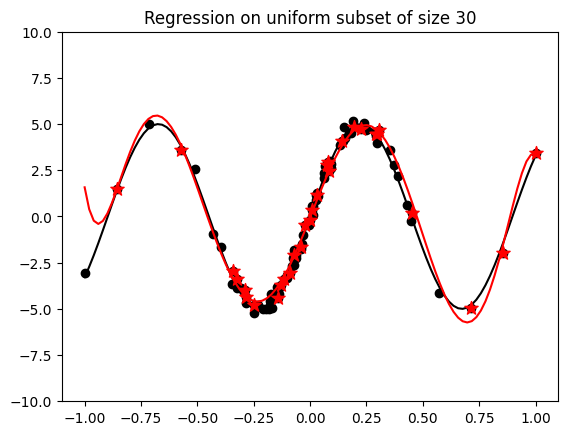

In [ ]:
solve_uniform(30)

Now we solve the subset selection with our coreset selection method. For this demo we simply use unweighted coreset points by setting the number of outer iterations to 1. Notice how we can achieve much lower MSE with coresets compared to uniform subsamples with the same size.

In [ ]:
poly_kernel = lambda x1, x2: np.dot(poly_features.transform(x1), poly_features.transform(x2).T)

bc = bilevel_coreset.BilevelCoreset(outer_loss_fn=loss_utils.weighted_mse,
                                    inner_loss_fn=loss_utils.weighted_mse, out_dim=1, max_outer_it=1,
                                    inner_lr=0.25, max_inner_it=500, logging_period=100)
coreset_inds, _ = bc.build_with_representer_proxy_batch(x, y.reshape(-1, 1), 30, kernel_fn_np=poly_kernel,
                                                        cache_kernel=True, start_size=3, inner_reg=reg)

def solve_coreset(subset_size):
    chosen_inds = coreset_inds[:subset_size]
    theta_hat = solve_regression(x_features[chosen_inds], y[chosen_inds])
    plot_solution(theta_hat, x[chosen_inds], y[chosen_inds], 'Regression on coreset of size {}'.format(subset_size))
    print('Coreset Size', subset_size, 'MSE', np.mean((x_features.dot(theta_hat) - y) ** 2))

30 MSE 0.11859634613228909


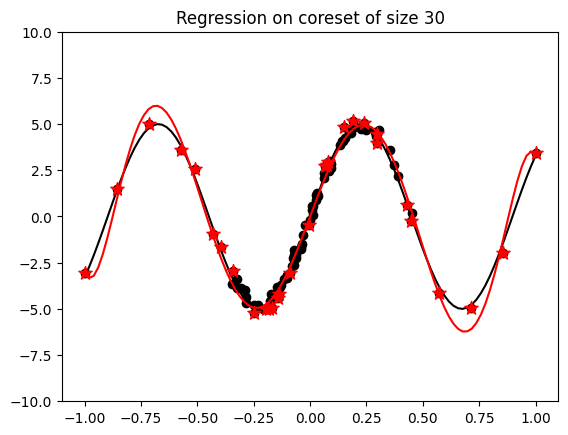

In [ ]:
solve_coreset(30)

## MNIST
We will create a subset of size 50 of the MNIST training data with uniform subsampling and with coresets generation. Then, we will train a CNN on these subset and evaluate its test accuracy.

###  Uniform sample

In [ ]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn.functional as F

subset_size = 50

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
same_seeds(0)

mnist_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
train_dataset = datasets.MNIST(root='data', train=True, transform=mnist_transforms, download=True)
test_dataset = datasets.MNIST('data', train=False, transform=mnist_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 896318.83it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134438.22it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 245626.91it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5096449.64it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Let's look at the training points we selected via uniform sampling.

Number of points selected per class [9 2 6 5 2 3 7 6 5 5]


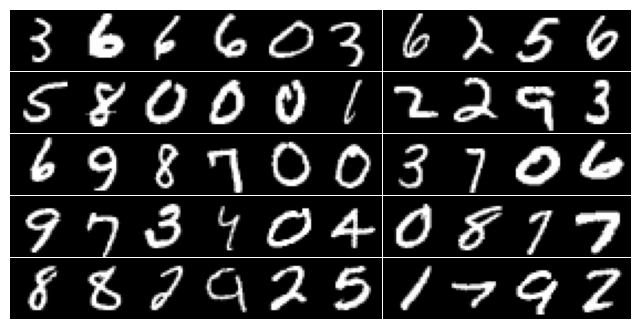

In [ ]:
# choose random inds
uniform_inds = np.random.choice(train_dataset.data.shape[0], subset_size, replace=False)
uniform_subset = Subset(train_dataset, uniform_inds)

print('Number of points selected per class', np.bincount(train_dataset.targets[uniform_inds].numpy()))

def plot_points(inds):
    X = train_dataset.data[inds].numpy()
    fig = plt.figure(figsize=(8, 13))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, len(inds) // 5),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

    for ax, im in zip(grid, X):
        # Iterating over the grid returns the Axes.
        ax.imshow(im, cmap='gray')
        ax.axis('off')
    plt.axis('off')

plot_points(uniform_inds)

Now we train a CNN on these 50 points, and measure its test accuracy on the full dataset, which should be around 72-74%.

In [ ]:
from tqdm.auto import tqdm
import models

def train_model(model, loader):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0)
    criterion = torch.nn.CrossEntropyLoss()
    pbar = tqdm(range(nr_epochs), desc="Training", unit="epoch")

    for epoch in pbar:
        model.train()
        training_loss = 0.0

        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            training_loss += loss.item()
            optimizer.step()

        pbar.set_postfix({'loss': training_loss / (batch_idx + 1)})

def test_model(model, loader):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()

    model.eval()
    pbar = tqdm(loader, desc="Testing", unit="batch")
    correct = 0
    testing_loss = 0.0

    with torch.no_grad():
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            testing_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            pbar.set_postfix({'loss': testing_loss / len(loader)})
    test_acc = 1. * correct / len(loader.dataset)
    return test_acc

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Testing:   0%|          | 0/469 [00:00<?, ?batch/s]

Uniform sample - Train accuracy 0.99365


Testing:   0%|          | 0/79 [00:00<?, ?batch/s]

Uniform sample - Test accuracy 0.9914


In [ ]:
nr_classes = 10
batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nr_epochs = 50

lenet5 = models.ConvNet(output_dim=nr_classes).to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_model(lenet5, train_loader)
print('Original LeNet - Train accuracy', test_model(lenet5, train_loader))
print('Original LeNet - Test accuracy', test_model(lenet5, test_loader))

### Coreset
We need to specify a proxy model for coreset generation for which we use the Neural Tangent Kernel corresponding to our CNN architecture. Note: calculating the NTK is much faster on GPU, so make sure to use a GPU backend.

In [ ]:
from jax import jit
from neural_tangents import stax
import neural_tangents as nt

_, _, kernel_fn = stax.serial(
        stax.Conv(6, (5, 5), (1, 1), padding='SAME', W_std=1., b_std=0.05),
        stax.Relu(),
        stax.Conv(16, (5, 5), (1, 1), padding='SAME', W_std=1., b_std=0.05),
        stax.Relu(),
        stax.Flatten(),
        stax.Dense(120, 1., 0.05),
        stax.Relu(),
        stax.Dense(84, 1., 0.05),
        stax.Relu(),
        stax.Dense(10, 1., 0.05))
kernel_fn = jit(kernel_fn, static_argnums=(2,))

def generate_cnn_ntk(X, Y):
    n = X.shape[0]
    m = Y.shape[0]
    K = np.zeros((n, m))
    for i in range(m):
        K[:, i:i + 1] = np.array(kernel_fn(X, Y[i:i + 1], 'ntk'))
    return K

proxy_kernel_fn = lambda x, y: generate_cnn_ntk(x.view(-1, 28, 28, 1).numpy(), y.view(-1, 28, 28, 1).numpy())

We are now ready to build the coreset. While we could optimize the coreset weights, for this demo we simply use unweighted coreset points.

In [ ]:
# work only on the first 10000 samples for speedup

limit = 10000

loader = torch.utils.data.DataLoader(train_dataset, batch_size=limit, shuffle=False)
X, y = next(iter(loader))

bc = bilevel_coreset.BilevelCoreset(outer_loss_fn=loss_utils.cross_entropy,
                                    inner_loss_fn=loss_utils.cross_entropy, out_dim=10,
                                    max_outer_it=10, outer_lr=0.05, max_inner_it=200)
coreset_inds, _ = bc.build_with_representer_proxy_batch(X, y, subset_size, proxy_kernel_fn, cache_kernel=True,
                                                        start_size=10, inner_reg=1e-7)

Coreset size 10, outer_loss 2.23, inner loss 0.000597
Coreset size 20, outer_loss 1.23, inner loss 0.000969
Coreset size 30, outer_loss 0.875, inner loss 0.00137
Coreset size 40, outer_loss 0.758, inner loss 0.00172
Coreset size 50, outer_loss 0.634, inner loss 0.00206


Number of points selected per class [4 2 6 6 6 6 5 5 5 5]


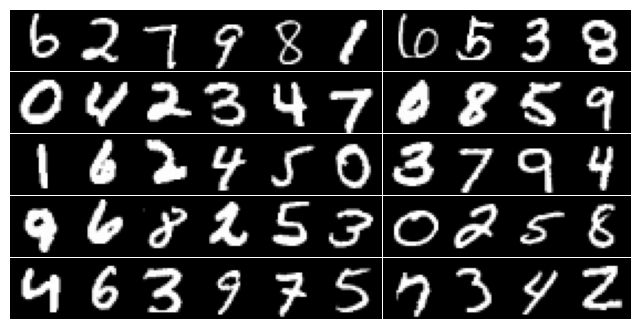

In [ ]:
print('Number of points selected per class', np.bincount(train_dataset.targets[coreset_inds].numpy()))
plot_points(coreset_inds)

We can notice that in each step, the method selects the sample that has the potential to increase the accuracy by the largest amount: the first 10 samples (first row) are picked from different classes, after which the method starts to diversify within the classes. Even though the dataset is balanced over classes, our method chooses more samples from harder classes.

In [ ]:
nr_epochs = 1000

coreset_net = models.ConvNet(output_dim=nr_classes).to(device)
coreset_subset = Subset(train_dataset, coreset_inds)
train_loader = torch.utils.data.DataLoader(coreset_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_model(coreset_net, train_loader)
print('Coreset LeNet - Train accuracy', test_model(coreset_net, train_loader))
print('Coreset LeNet - Test accuracy', test_model(coreset_net, test_loader))

Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Testing:   0%|          | 0/1 [00:00<?, ?batch/s]

Coreset - Train accuracy 1.0


Testing:   0%|          | 0/79 [00:00<?, ?batch/s]

Coreset - Test accuracy 0.8936


The test accuracy of the LeNet-5 on the coreset is only 10% lower than the original LeNet-5.

In [ ]:
def test_with_logits(model, coreset_model, loader):
    model.eval()
    logits = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = F.softmax(model(data), dim=1)
            coreset_output = F.softmax(coreset_model(data), dim=1)
            logits.append((data, output, coreset_output, target))

    return logits

logits = test_with_logits(lenet5, coreset_net, test_loader)

In [ ]:
prioritized_test_data = []

# calculate the similarity score between the logits from
# original DNN and coreset-trained DNN
# reorder test cases based on the similarity score
def test_case_prioritization(logits):
    result = []
    probs = torch.cat([item[1] for item in logits], dim=0).cpu().numpy()
    coreset_probs = torch.cat([item[2] for item in logits], dim=0).cpu().numpy()
    inputs = torch.cat([item[0] for item in logits], dim=0).cpu().numpy()
    targets = torch.cat([item[3] for item in logits], dim=0).cpu().numpy()
    for i in range(probs.shape[0]):
        item = probs[i]
        coreset_item = coreset_probs[i]
        similarity_score = F.cosine_similarity(torch.tensor(item).unsqueeze(0), torch.tensor(coreset_item).unsqueeze(0))
        result.append({'similarity_score': similarity_score,
                       'probabilities': item,
                       'input': inputs[i],
                       'target': targets[i]})
    result = sorted(result, key=lambda x: x['similarity_score'], reverse=False)
    return result

In [ ]:
prioritized_test_data = test_case_prioritization(logits)

In [ ]:
from torch.utils.data import TensorDataset

inputs = torch.stack([torch.from_numpy(item['input']) for item in prioritized_test_data])
targets = torch.stack([torch.tensor(item['target']) for item in prioritized_test_data])
tensor_dataset = TensorDataset(inputs, targets)
prioritized_loader = torch.utils.data.DataLoader(tensor_dataset, batch_size=1, shuffle=False)

In [ ]:
def test_with_APFD(model, loader):
    model.to(device)
    model.eval()

    TFs = 10 * [0]

    with torch.no_grad():
        for ids, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            category = output.argmax(dim=1, keepdim=True)
            if category != target and TFs[target] == 0:
                TFs[target] = ids + 1

            if all(TFs):
                break

    APFD = 1 - (sum(TFs) / (10 * len(loader))) + 1 / (2 * len(loader))

    return APFD

print('LeNet - APFD', test_with_APFD(lenet5, prioritized_loader))

LeNet - APFD 0.94875
